In [1]:
import pandas as pd

In [41]:
dataset = pd.read_csv('./dataset/SMSSpamCollection', sep="\t")
dataset.columns = ['spam', 'text']
dataset.spam = dataset.spam.map({'ham': 0, 'spam': 1})

print(f"Size of the dataset: {dataset.shape[0]}")

dataset.head(10)

Size of the dataset: 5571


,spam,text
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...
5,0,Even my brother is not like to speak with me. ...
6,0,As per your request 'Melle Melle (Oru Minnamin...
7,1,WINNER!! As a valued network customer you have...
8,1,Had your mobile 11 months or more? U R entitle...
9,0,I'm gonna be home soon and i don't want to tal...


# Preprocessing

In [3]:
import re
from nltk.tokenize import WhitespaceTokenizer

### 1. Cleaning:
    Clear and get only the main part from the dataset
    Ex: remove the tags of the html.
    Ex: filter the texts in PDF and etc.

In [4]:
def clean(text):
    # Remove the HTML tags
    text = re.sub("<!--?.*?-->","",text)
    text = re.sub("<.*?>","",text)
    
    return text

### 2. Normalization:
    Remove the pontuation, tags, put everything in same case and etc.

In [5]:
def normalize(text):
    # Convert to lower case
    text = text.lower()
    
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ",text)
    
    text = text.replace('  ', ' ')
    
    return text

### 3. Tokenization:
    Split the text in words spliting by the whitespaces.

In [6]:
def tokenizer(text):    
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens

### 4. Stop Words:
    They are words witch don't get no one meaning, they are just used to complement the context,
    and to connect the terms.
    Ex: 'i', 'you', 'in', 'out', 'are', 'the'

In [7]:
from nltk.corpus import stopwords

# Remove the stop words, they are words witch don't give no one especific meaning
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords.words("english")]

### 5. Stemming:
    Takes of the variation of the words and remove the finally to combine than.
    Ex: 'change', 'changing', 'changes' => 'chang'


### 6. Lemmatization:
    Takes the variation of the same word and convert to the same one (Noun).
    Ex: 'is', 'were', 'was' => 'be'
    Ex: 'ones' => 'one'

    Part of Speech(PoS) (Verb):
    Ex: 'bored' => 'bore'
    Ex: 'stating' => 'start'

In [17]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Remove the pural
# Remove the verb conjugation
def stem(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

# Remove the personality
def lem(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

### 7. Tag filtering
    Filter the words according with the sintaxe definition like a noun, verbs, adverbs e etc.

In [18]:
import nltk

# RB | RB | JJ | NN | NNP | JJ | JJS | IN | VB | VBZ | VBD | VBG

# IN = preposition/subordinating conjunction

# RB = adverb very, silently
# RBR = adverb, comparative better
# RBS = adverb, superlative best
# RP = particle give up

# IN = preposition/subordinating conjunction
# JJ = adjective ‘big’
# JJR = adjective, comparative ‘bigger’
# JJS = adjective, superlative ‘biggest’

# VB verb, base form take
# VBD verb, past tense took
# VBG verb, gerund/present participle taking
# VBN verb, past participle taken
# VBP verb, sing. present, non-3d take
# VBZ verb, 3rd person sing. present takes

# Filter using regular array
def filter_tokens(tokens):
    tags = [x[1] for x in nltk.pos_tag(list(tokens))]
    filters = ("RB", "RBR", "RBS", "RP", "JJ", "JJR", "JJS", "JJ", "VB")
    
    return [tokens[i] for i in range(len(tokens)) if tags[i] in filters]

### 8. Remove the numbers
    In this case we will remove the numbers inside because can variaty accourding with the wty

In [24]:
def transform_numbers(tokens):
    return ["number" if bool(re.search(r'\d', w)) else w for w in tokens]

# Bag of Words

    We wee create a our vocabullary of words

In [25]:
all_words = " ".join(list(dataset.text))

text = normalize(clean(all_words))
print("> Normalized!")

tokens = tokenizer(text)
print("> Tokenized!")

tokens = remove_stopwords(tokens)
print("> Removed the stop words!")

# tokens = stem(tokens)
tokens = lem(tokens)
print("> Merged the term to the root form!")

# tokens = filter_tokens(tokens)
# print("> Filtred by tags witch get more meaning!")

tokens = transform_numbers(tokens)
print("> Transformed the numbers")

print("\nColection [:100]:\n")
print(tokens[:100])

> Normalized!
> Tokenized!
> Removed the stop words!
> Merged the term to the root form!
> Transformed the numbers

Colection [:100]:

['ok', 'lar', 'joking', 'wif', 'u', 'oni', 'free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply', 'u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say', 'nah', 'think', 'go', 'usf', 'life', 'around', 'though', 'freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv', 'even', 'brother', 'like', 'speak', 'treat', 'like', 'aid', 'patent', 'per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'caller', 'press', 'copy', 'friend', 'callertune', 'winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hour', 'mobile', 'month', 'u']


### Get the frequency of the words

In [26]:
import nltk

frequency = nltk.FreqDist(tokens)

# Create the bag of words dataframe
bag_of_words = pd.DataFrame({"words": list(frequency.keys()), "frequency": list(frequency.values())})

# Order by the Frequency
bag_of_words.sort_values(by="frequency", ascending=False, inplace=True)
bag_of_words.reset_index(drop=True, inplace=True)

# Save the bag of words
bag_of_words.to_csv('./dataset/bag-of-words.csv', index=True)

print(f"Back of words size: {bag_of_words.shape[0]}")

print(bag_of_words.shape[0])
bag_of_words.head(5)

Back of words size: 7125
7125


,words,frequency
0,u,1295
1,call,641
2,get,408
3,ur,391
4,gt,318


### Plot the frequency in Word Cloud

In [27]:
def to_single_str(words, frequency):
    words = list(words)
    frequency = list(frequency)
    
    return " ".join([(words[i] + " ") * frequency[i] for i in range(len(frequency))])

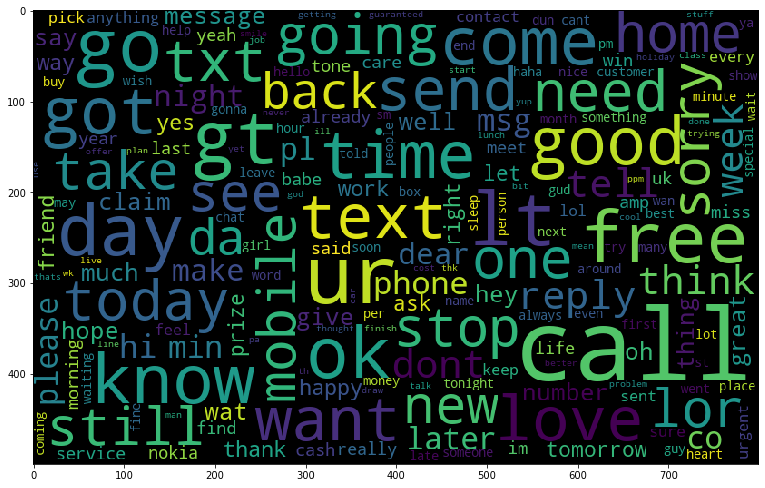

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(to_single_str(bag_of_words["words"], bag_of_words["frequency"]))

plt.figure(figsize=(13, 13))
plt.imshow(word_cloud)
plt.show()

# TF-IDF

### Config

In [42]:
# Load the dictinary
bag_of_words = pd.read_csv('./dataset/bag-of-words.csv')
bag_of_words_array = bag_of_words.words.values

# Load the dataset
inputs = dataset.text.values

### Implemetation

In [43]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a tf-idf function
def tf_idf(txt, vocabulary=None):
    txt = list(txt)

    tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', vocabulary=vocabulary)
    txt_transformed = tf.fit(txt).transform(txt)

    return txt_transformed.toarray(), tf.get_feature_names()

In [46]:
tfidf, feature_names = tf_idf(inputs, bag_of_words_array)

view = pd.DataFrame(tfidf, columns=feature_names)
view.head(10)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


,u,call,get,ur,gt,lt,go,day,ok,free,...,cast,thkin,resubbing,shadow,breadstick,saeed,purple,yelow,brown,bitching
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.99054,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,4.191608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.99054,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,3.315412,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,3.315412,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,8.383216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
del view